Each label is encoded, 0-9, representing a class. Each image is a 3072 length array. The images are 32x32, so the first 1024 values correspond to the red channel, followed by the green and the red.

In [1]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [2]:
data = unpickle('cifar-10-batches-py/data_batch_1')

In [3]:
x = data[b'labels']
y = data[b'data']

In [4]:
data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

# asdfadfasfas

In [14]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from skimage import io, transform
from torchvision import utils, transforms
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Image Preprocessing Functions

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        h, w = image.shape[:2]
#         h, w = 32, 32
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
               
        return {'image': img, 'label': label}
    

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)
        
        image = image[top: top+new_h,
                      left: left+new_w]
        
        return {'image': image, 'label': label}
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        # swap color axis because
        # numpy iamge: HxWxC
        # torch image: CxHxW
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': label}

# Create the Dataset Object

In [8]:
class CIFARDataset(Dataset):
    def __init__(self, batch_lst:list, transform=None):
        """To be used when iterating over the 
        files within the root directory"""
        data = unpickle(batch_dir)
        self.labels = data[b'labels']
        self.images = [cifar10_to_rgb(img) for img in data[b'data']]
#         self.images = cifar10_to_rgb(data[b'data'])
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx:int) -> dict:
        """For any index in the range of img_lst
        it maps image to the image values
        and species to the type of bird"""
        sample = {'image': self.images[idx], 
                  'label': self.labels[idx]}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [9]:
def cifar10_to_rgb(arr_lst):
    ___ = []
    for k in range(32):
        __ = []
        for j in range(32):
            _ = []
            for i in range(3):
                _ += [arr_lst[1024*i+32*j+k]]
            __ += [_]
        ___ += [__]
    return np.array(___)

In [12]:
CIFAR = CIFARDataset('cifar-10-batches-py/data_batch_1',
                     transform=transforms.Compose([
#                                       Rescale(256),
                                      RandomCrop(30),
                                      ToTensor()
                                  ]))

In [20]:
train_dataset, test_dataset = train_test_split(CIFAR, random_state=88)

In [ ]:
# upload_root_dir = Path('uploaded_img/')
# upload_img_lst = os.listdir('uploaded_img/')
# # upload_birds_dataset = BirdDataset(upload_root_dir, upload_img_lst)

# upload_bird_dataset = BirdDataset(upload_root_dir, upload_img_lst,
#                                   transform=transforms.Compose([
#                                       Rescale(256),
#                                       RandomCrop(224),
#                                       ToTensor()
#                                   ]))

In [ ]:
# predictions = net(upload_tensor.reshape((1, 3, 224, 224)))

In [ ]:
# predictions = predictions.tolist()[0]

In [ ]:
# predictions.index(max(predictions))

In [ ]:
# predictions[96]

8
(32, 32, 3)


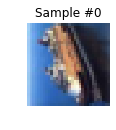

8
(32, 32, 3)


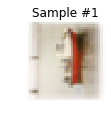

3
(32, 32, 3)


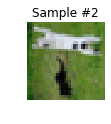

9
(32, 32, 3)


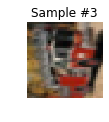

In [22]:
def show_img(image):
    plt.imshow(image)
    plt.pause(0.001)
    

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    
    print(sample['label'])
    print(sample['image'].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
#     show_duck(sample['image'])
    show_img(sample['image'])
    
    if i == 3:
        plt.show()
        break

# Use the Data Loader to Implement Batches

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [ ]:
train_birds_dataset = BirdDataset(train_root_dir, train_img_lst,
                                  transform=transforms.Compose([
                                                Rescale(256),
                                                RandomCrop(224),
                                                ToTensor()
                                  ]))
test_birds_dataset = BirdDataset(test_root_dir, test_img_lst,
                                 transform=transforms.Compose([
                                                 Rescale(256),
                                                 RandomCrop(224),
                                                 ToTensor()
                                 ]))

In [ ]:
train_dataloader = DataLoader(train_birds_dataset, batch_size=4,
                              shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_birds_dataset, batch_size=4,
                              shuffle=True, num_workers=4)
 
def show_birds_batch(sample_batched):
    """Show species images for a batch"""
    images_batch, species_batch = sample_batched['image'], sample_batched['species']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):      
        plt.title('Batch from dataloader')
    
    
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['species'])
    plt.figure()
    show_birds_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    
    if i_batch == 3:
        break

# Train The Model

### Define The Network

In [ ]:
class Network(nn.Module):
    def __init__(self, dropout_rate=0):
        super(Network, self).__init__()
        # Conv arguments were arbitrarily changed to require less model parameters
        self.conv1 = nn.Conv2d(3, 4, 8, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 10, 8, stride=2)
        # First linear argument is a function of image size and conv parameters
        self.fc1 = nn.Linear(10*12*12, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 200)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*12*12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# net = Network(0.5)

### Create a Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, 
                      momentum=0.9, weight_decay=0.00001)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

### Train For Real

In [ ]:
def train(num_epocs):
    losses = []
    for epoch in range(num_epocs):
        net.train()
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            inputs = data['image'].float()
            labels = data['species']
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            losses += [loss.item()]
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 200 == 199:
                print(f'[{epoch+1}, {i+1}] loss: {running_loss/200}')
                running_loss = 0.0
        test()

                
def test():
    losses = []
    net.eval()
    for i, data in enumerate(test_dataloader, 0):
        inputs = data['image'].float()
        labels = data['species']
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses += [loss.item()]
    print(f'Test Loss: {np.mean(losses)}')

    
# train(10)

In [ ]:
train(10)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.0001,
                      momentum=0.9, weight_decay=0.00001)
train(5)

In [ ]:
train(10)

In [ ]:
torch.save(net, 'models/dropout.pt')

In [ ]:
net = torch.load('models/dropout.pt')

In [ ]:
train(10)

In [ ]:
# How to save model
# torch.save(net.state_dict(), 'models/dropout_not_pickle.pt')

In [ ]:
# How to load model

net = Network(0.5)
net.load_state_dict(torch.load('models/current_model.pt'))
net.eval()

In [ ]:
train(10)

In [ ]:
train(5)

In [ ]:
torch.save(net.state_dict(), 'models/dropout_not_pickle.pt')